This builds on the geeet-analysis notebook to do some analysis on the exported csv from that notebook.

In [ ]:
#imports all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import metloom as mt

# Load the exported CSV data
df = pd.read_csv(r"C:\School\GITHUB RESPOSITORIES\thesis\data\DC_ET_zonalstats.csv")

In [ ]:
#check the first few rows of the data
df.head()

In [ ]:
#pad zone_id with leading zeros that got lost during export
df['zone_id_str'] = df['zone_id'].apply(lambda x: str(int(x)).zfill(7))
df

In [ ]:
#set the datetime as index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# sort by index
df.sort_index(inplace=True)
df.head()

In [31]:
#pivot the data to have zone_ids as columns and months as rows, with mean ET values

pivot_mean = df.pivot_table(
    index='datetime',          # each row = one datetime
    columns='zone_id',       # each column = one zone_id
    values='mean_ET',         # values to fill
    fill_value=None              # keeps missing values as NaN
)

# Create a full monthly date range that has missing months included
full_index = pd.date_range(
    start=pivot_mean.index.min(),
    end=pivot_mean.index.max(),
    freq='MS'  # Month Start
)

pivot_mean = pivot_mean.reindex(full_index)

#add attributes to the pivoted dataframe to make zone_id readable
# Take one row per zone for attributes
zone_attrs = df.drop_duplicates(subset='zone_id')[['zone_id','aspect_class','elev_class','slope_class','nlcd']]

print(pivot_mean.shape)
print(df['zone_id'].nunique())

#merge attributes with pivoted dataframe
pivot_mean.attrs = zone_attrs.set_index('zone_id').to_dict(orient='index')
pivot_mean.attrs



(150, 405)
405


{52: {'aspect_class': 0, 'elev_class': 0, 'slope_class': 0, 'nlcd': 52},
 152: {'aspect_class': 0, 'elev_class': 0, 'slope_class': 1, 'nlcd': 52},
 242: {'aspect_class': 0, 'elev_class': 0, 'slope_class': 2, 'nlcd': 42},
 252: {'aspect_class': 0, 'elev_class': 0, 'slope_class': 2, 'nlcd': 52},
 342: {'aspect_class': 0, 'elev_class': 0, 'slope_class': 3, 'nlcd': 42},
 352: {'aspect_class': 0, 'elev_class': 0, 'slope_class': 3, 'nlcd': 52},
 442: {'aspect_class': 0, 'elev_class': 0, 'slope_class': 4, 'nlcd': 42},
 452: {'aspect_class': 0, 'elev_class': 0, 'slope_class': 4, 'nlcd': 52},
 10052: {'aspect_class': 0, 'elev_class': 1, 'slope_class': 0, 'nlcd': 52},
 10142: {'aspect_class': 0, 'elev_class': 1, 'slope_class': 1, 'nlcd': 42},
 10152: {'aspect_class': 0, 'elev_class': 1, 'slope_class': 1, 'nlcd': 52},
 10171: {'aspect_class': 0, 'elev_class': 1, 'slope_class': 1, 'nlcd': 71},
 10242: {'aspect_class': 0, 'elev_class': 1, 'slope_class': 2, 'nlcd': 42},
 10252: {'aspect_class': 0, '

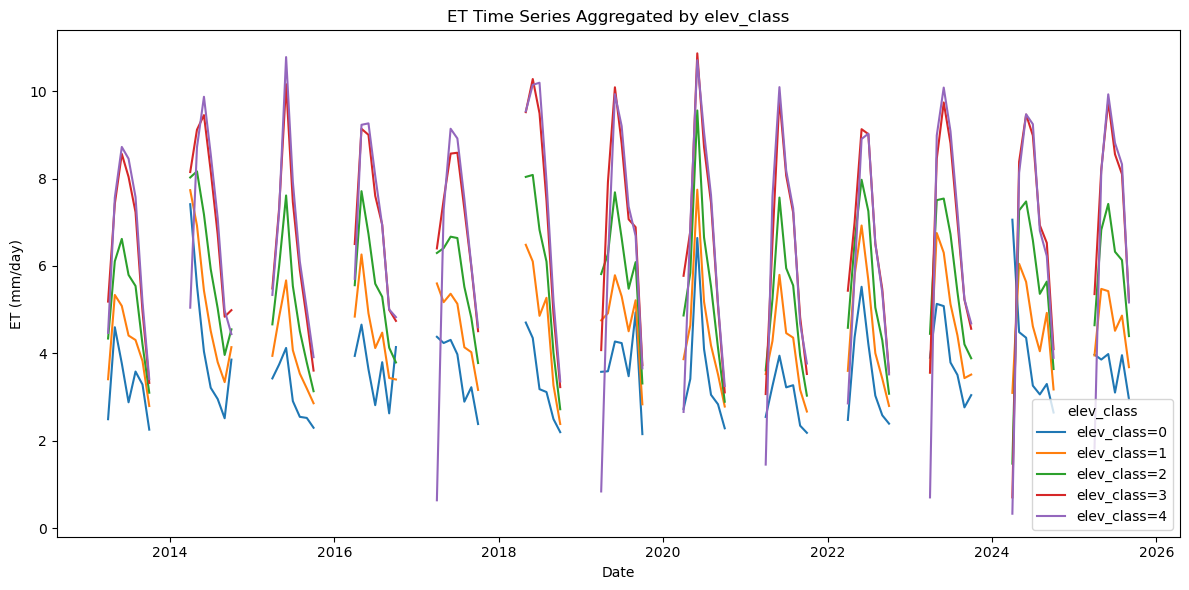

In [32]:
def plot_et_by_attribute(pivot_df, attr_name, agg_func='mean'):
    """
    Plot ET time series aggregated by a given zone attribute.
    
    Parameters:
        pivot_df : pd.DataFrame
            Pivoted dataframe with datetime as index, zone_id as columns, ET values as entries.
        attr_name : str
            Name of the attribute to group by ('elev_class', 'slope_class', 'aspect_class', 'nlcd').
        agg_func : str
            Aggregation function ('mean', 'median', etc.).
    """
    # Convert pivot_df.attrs to DataFrame for lookup
    attrs_df = pd.DataFrame.from_dict(pivot_df.attrs, orient='index')
    
    # Map zone_id columns to attribute
    zone_attr_map = attrs_df[attr_name].to_dict()
    
    # Group columns by attribute
    grouped = {}
    for zone_id in pivot_df.columns:
        key = zone_attr_map.get(zone_id)
        if key not in grouped:
            grouped[key] = []
        grouped[key].append(zone_id)
    
    # Aggregate ET for each attribute group
    agg_df = pd.DataFrame(index=pivot_df.index)
    for key, cols in grouped.items():
        if agg_func == 'mean':
            agg_df[key] = pivot_df[cols].mean(axis=1, skipna=True)
        elif agg_func == 'median':
            agg_df[key] = pivot_df[cols].median(axis=1, skipna=True)
        else:
            raise ValueError(f"Unsupported agg_func: {agg_func}")
    
    # Plot
    plt.figure(figsize=(12, 6))
    for col in agg_df.columns:
        plt.plot(agg_df.index, agg_df[col], label=f"{attr_name}={col}")
    
    plt.xlabel("Date")
    plt.ylabel("ET (mm/day)")
    plt.title(f"ET Time Series Aggregated by {attr_name}")
    plt.legend(title=attr_name)
    plt.tight_layout()
    plt.show()
    
    return agg_df

# Example usage: plot by elevation class
agg_et_elev = plot_et_by_attribute(pivot_mean, 'elev_class', agg_func='mean')


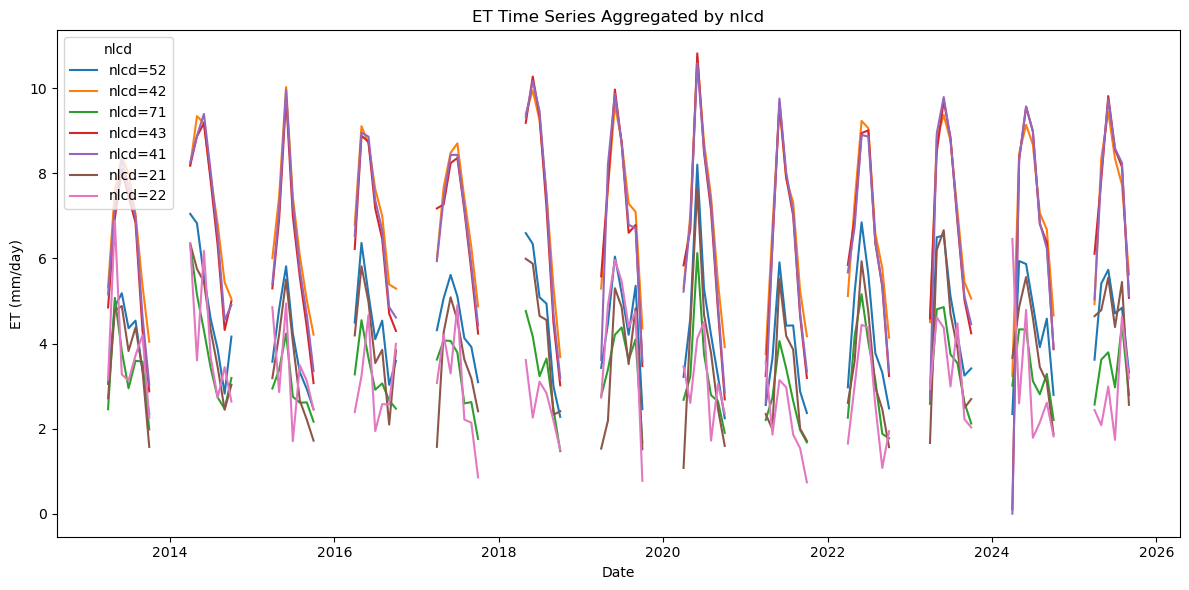

In [45]:
agg_et_nlcd = plot_et_by_attribute(pivot_mean, 'nlcd', agg_func='mean')

C:\Users\maxwe\AppData\Local\Temp\ipykernel_388\4239837253.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


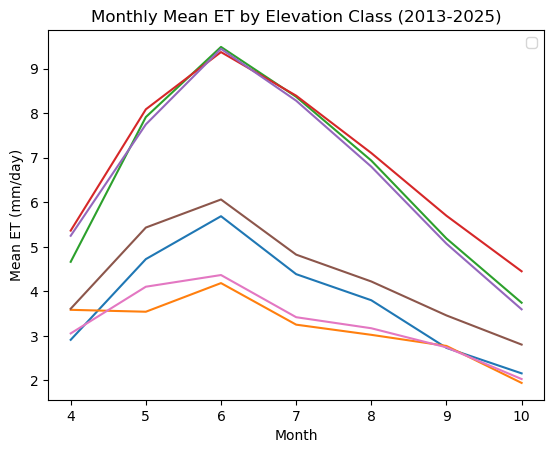

In [48]:


def monthly_mean_by_elevation(pivot_df, months=range(4,11)):
    """
    Compute average ET for each month across all years, aggregated by elevation class.

    Parameters
    ----------
    pivot_df : pd.DataFrame
        Pivoted DataFrame with datetime index and zone_id columns (ET values)
    months : iterable
        Growing season months (default April–October)

    Returns
    -------
    pd.DataFrame
        DataFrame with index = month (1–12), columns = elev_class, values = mean ET
    """
    # Access zone attributes
    zone_attrs = pd.DataFrame.from_dict(pivot_df.attrs, orient='index')
    
    # Keep only growing season months
    gs_df = pivot_df[pivot_df.index.month.isin(months)]
    
    # Extract month number from datetime index
    gs_df = gs_df.copy()
    gs_df['month'] = gs_df.index.month
    
    # Melt to long format
    long_df = gs_df.melt(id_vars='month', var_name='zone_id', value_name='ET')
    
    # Join with attributes to get elevation class
    long_df = long_df.merge(zone_attrs[['nlcd']], left_on='zone_id', right_index=True)
    
    # Group by month and elevation class
    monthly_elev_mean = long_df.groupby(['month','nlcd'])['ET'].mean().unstack('nlcd')
    
    return monthly_elev_mean

#plotting monthly mean ET by elevation class
monthly_elev_mean = monthly_mean_by_elevation(pivot_mean)

plt.plot(monthly_elev_mean.index, monthly_elev_mean)
plt.xlabel("Month")
plt.ylabel("Mean ET (mm/day)")
plt.title("Monthly Mean ET by Elevation Class (2013-2025)")
plt.legend()
plt.show()
